In [ ]:
# ============================================================================
# EXAMEN INTEGRADOR: ANÁLISIS DE ÁREA PROTEGIDA CON PYTHON Y GIS
# ============================================================================
# Este notebook integra diferentes técnicas de análisis geoespacial para
# estudiar áreas protegidas utilizando datos de OpenStreetMap, indexación H3
# e imágenes satelitales para calcular índices de vegetación.

# ----- Instalación de bibliotecas necesarias -----
!pip install osmnx h3 pystac-client contextily gdal rasterio -q
#geopandas folium  matplotlib  shapely requests

# ----- Importación de bibliotecas -----
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import GeoJson, Marker, LayerControl
import osmnx as ox
import h3
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import Polygon, box, mapping
from pystac_client import Client
import requests
import os
import json
import contextily as cx
from shapely.geometry import shape

# ----- Configuración inicial -----
# Configuración de OSMnx (versión actualizada)
ox.settings.use_cache = True
ox.settings.log_console = False

# Configuración de matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# ----- Creamos directorios para el proyecto -----
!mkdir -p data/examen/descargas
!mkdir -p data/examen/resultados

Buscando área protegida: Reserva Paisajística Nor Yauyos-Cochas
✅ Área protegida obtenida desde OSM por nombre: Reserva Paisajística Nor Yauyos-Cochas


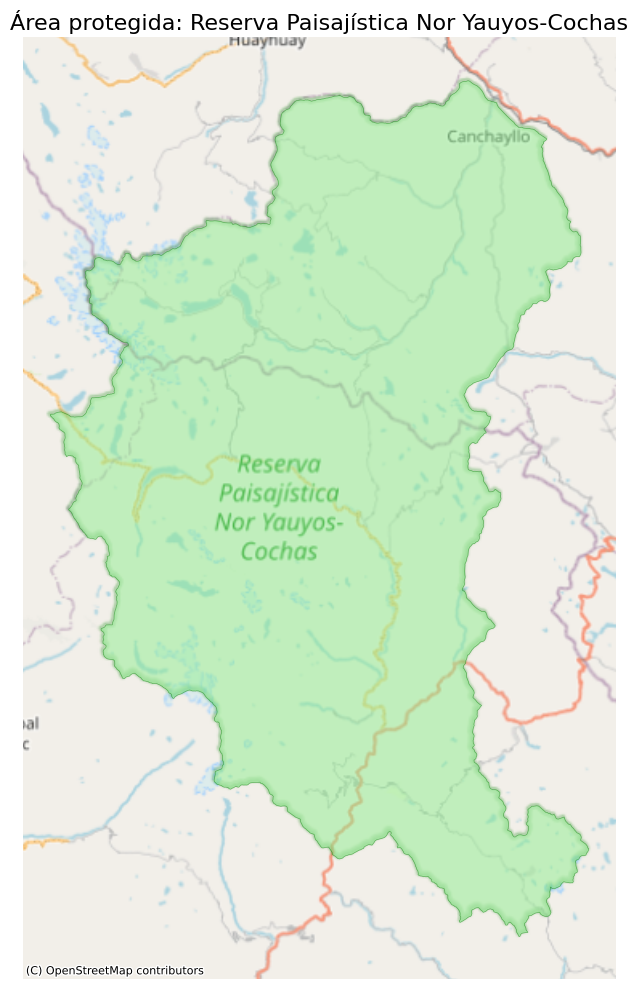

📊 Información básica sobre el área protegida:
- Nombre: Reserva Paisajística Nor Yauyos-Cochas
- Sistema de coordenadas: epsg:4326
- Área aproximada: 2329.69 km²
- Bounding box (oeste, sur, este, norte): [-76.0880701, -12.4611623, -75.6338948, -11.755064]


In [ ]:
# ============================================================================
# OBTENCIÓN DEL ÁREA PROTEGIDA
# ============================================================================
# En esta sección, obtendremos el polígono de un área protegida
# usando OpenStreetMap con las etiquetas correctas para parques nacionales

# ----- Definir el área protegida a analizar -----
# El usuario puede cambiar este nombre por cualquier otra área protegida conocida
area_nombre = "Reserva Paisajística Nor Yauyos-Cochas" #"Parque Nacional Tingo María"
print(f"Buscando área protegida: {area_nombre}")

# ----- Método 1: Intentar obtener desde OpenStreetMap por nombre -----
try:
    # Intentamos usar geocode_to_gdf para obtener el área
    gdf_area = ox.geocode_to_gdf(area_nombre)
    print(f"✅ Área protegida obtenida desde OSM por nombre: {area_nombre}")
except Exception as e:
    print(f"❌ Error al obtener desde OSM por nombre: {e}")

    # ----- Método 2: Intentar obtener usando las etiquetas correctas de OSM -----
    try:
        print("Intentando obtener desde OSM usando etiquetas específicas...")
        # Definimos un bounding box aproximado para buscar (América del Sur para este ejemplo)
        bbox = [-80, -40, -40, 10]  # [oeste, sur, este, norte]

        # Usamos las etiquetas correctas según la wiki de OSM para parques nacionales
        tags = {
            'boundary': 'national_park',
            'protect_class': '2',
            'name': area_nombre
        }

        # Obtenemos todos los parques nacionales en el bbox
        gdf_parques = ox.features_from_bbox(
            bbox[3], bbox[1], bbox[2], bbox[0],  # north, south, east, west
            tags={'boundary': 'national_park'}
        )

        # Filtramos por nombre similar
        import re
        pattern = re.compile(re.escape(area_nombre.lower().replace('parque nacional', '').strip()))

        # Buscamos coincidencias en el nombre
        encontrado = False
        for idx, row in gdf_parques.iterrows():
            if 'name' in row and row['name'] is not None:
                if pattern.search(row['name'].lower()):
                    gdf_area = gdf_parques.loc[[idx]].copy()
                    encontrado = True
                    print(f"✅ Área protegida encontrada en OSM: {row['name']}")
                    break

        if not encontrado:
            raise ValueError("No se encontró el área protegida")

    except Exception as e:
        print(f"❌ Error al obtener desde OSM con etiquetas: {e}")
        # Utilizamos un área predefinida como respaldo
        print("Usando un bounding box predefinido como alternativa")

        # Definimos áreas protegidas conocidas y sus bounding boxes
        areas_conocidas = {
            "Parque Nacional Iguazú": [-54.6, -25.7, -54.3, -25.4],  # [oeste, sur, este, norte]
            "Parque Nacional Nahuel Huapi": [-71.7, -41.3, -71.0, -40.7],
            "Parque Nacional Yellowstone": [-111.2, 44.1, -109.8, 45.1],
            "Parque Nacional Torres del Paine": [-74.0, -51.3, -72.9, -50.8]
        }

        # Usamos el área conocida si está en nuestro diccionario
        if area_nombre in areas_conocidas:
            bbox = areas_conocidas[area_nombre]
        else:
            # Por defecto, usamos Iguazú
            area_nombre = "Parque Nacional Iguazú"
            bbox = areas_conocidas[area_nombre]

        # Creamos un GeoDataFrame con el bounding box
        gdf_area = gpd.GeoDataFrame(
            {'name': [area_nombre]},
            geometry=[box(*bbox)],
            crs="EPSG:4326"
        )

# ----- Visualización básica del polígono -----
fig, ax = plt.subplots(figsize=(12, 10))
gdf_area.plot(ax=ax, color='lightgreen', edgecolor='green', alpha=0.5)
cx.add_basemap(ax, crs=gdf_area.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.title(f"Área protegida: {area_nombre}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# ----- Información básica sobre el área -----
print(f"📊 Información básica sobre el área protegida:")
print(f"- Nombre: {area_nombre}")
print(f"- Sistema de coordenadas: {gdf_area.crs}")
print(f"- Área aproximada: {gdf_area.to_crs('EPSG:3857').geometry.area.iloc[0]/1000000:.2f} km²")
print(f"- Bounding box (oeste, sur, este, norte): {gdf_area.total_bounds.tolist()}")

# ----- Guardamos el polígono para uso posterior -----
gdf_area.to_file("data/examen/area_protegida.geojson", driver="GeoJSON")

In [ ]:
# ============================================================================
# CREACIÓN DE GRILLA H3
# ============================================================================
# Creamos una grilla hexagonal H3 sobre el área protegida

# Instalamos h3 si es necesario
# !pip install h3 -q

import h3
from shapely.geometry import Polygon, mapping

# Esta función convierte un polígono a celdas H3
def shapely_to_h3_cells(geometry, resolution):
    """
    Convierte un polígono Shapely a celdas H3
    """
    # Obtener la representación GeoJSON del polígono
    geojson = mapping(geometry)

    # Usar la función geo_to_cells para convertir a celdas H3
    h3_cells = h3.geo_to_cells(geojson, resolution)

    return list(h3_cells)

# Obtener la geometría del área protegida
geometry = gdf_area.geometry.iloc[0]

# Convertir a celdas H3 con resolución 6
resolution = 9 # 6
h3_cells = shapely_to_h3_cells(geometry, resolution)

print(f"Se generaron {len(h3_cells)} celdas H3 de resolución {resolution}")

# Convertir a polígonos para visualización
h3_polygons = []
for cell in h3_cells:
    # Obtener el límite como [lat, lng]
    boundary = h3.cell_to_boundary(cell)
    # Convertir a formato Shapely [lng, lat]
    coords = [(lng, lat) for lat, lng in boundary]
    h3_polygons.append(Polygon(coords))

# Crear GeoDataFrame
h3_gdf = gpd.GeoDataFrame(
    {'h3_index': h3_cells},
    geometry=h3_polygons,
    crs=gdf_area.crs
)

# Visualizar con matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
gdf_area.plot(ax=ax, color='green', alpha=0.5, edgecolor='black')
h3_gdf.plot(ax=ax, color='orange', alpha=0.3, edgecolor='blue')
plt.title(f'Área protegida con grilla H3 (resolución {resolution})')
plt.axis('off')
plt.show()

# Mostrar algunos índices como ejemplo
print("Ejemplos de índices H3:")
for i, cell in enumerate(h3_cells[:8]): #5
    print(f"{i+1}: {cell}")

# Visualizar con folium
centroid = geometry.centroid
center = [centroid.y, centroid.x]

m = folium.Map(location=center, zoom_start=11)

# Añadir el polígono del área protegida
folium.GeoJson(
    gdf_area,
    name='Área Protegida',
    style_function=lambda x: {
        'fillColor': 'green',
        'color': 'black',
        'fillOpacity': 0.4,
        'weight': 2
    }
).add_to(m)

# Añadir las celdas H3
folium.GeoJson(
    h3_gdf,
    name='Celdas H3',
    style_function=lambda x: {
        'fillColor': 'orange',
        'color': 'blue',
        'fillOpacity': 0.3,
        'weight': 1
    }
).add_to(m)

# Añadir control de capas
folium.LayerControl().add_to(m)

# Mostrar el mapa
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ============================================================================
# IMÁGENES SATELITALES CON STAC
# ============================================================================
# Descargamos imágenes satelitales Sentinel-2 sobre el área protegida

# Instalamos pystac-client
# !pip install pystac-client requests -q

from pystac_client import Client
import requests
import os
from datetime import datetime, timedelta

# Configuración para la búsqueda STAC
print("Configurando cliente STAC para búsqueda de imágenes...")
STAC_URL = 'https://earth-search.aws.element84.com/v1'
client = Client.open(STAC_URL)

# Obtener el bounding box del área protegida
bbox = gdf_area.total_bounds.tolist()  # [minx, miny, maxx, maxy]
print(f"Bounding box del área: {bbox}")

# Definir el rango de fechas (últimos 6 meses)
today = datetime.now()
six_months_ago = today - timedelta(days=1028) # 180
date_range = f"{six_months_ago.strftime('%Y-%m-%d')}/{today.strftime('%Y-%m-%d')}"

# Definir parámetros de búsqueda
search_parameters = {
    "collections": ["sentinel-2-l2a"],
    "bbox": bbox,
    "datetime": date_range,
    "query": {"eo:cloud_cover": {"lt": 20}},  # Menos del 20% de nubes
    "limit": 20
}

# Realizar la búsqueda
print("Buscando imágenes Sentinel-2...")
search = client.search(**search_parameters)
items = search.get_all_items()
print(f"Se encontraron {len(items)} imágenes que cumplen los criterios")

# Si hay imágenes disponibles, seleccionamos la mejor (menor cobertura de nubes)
if len(items) > 0:
    # Crear lista para ordenar por cobertura de nubes
    image_list = []
    for item in items:
        date = item.properties.get("datetime", "")[:10]  # YYYY-MM-DD
        cloud_cover = item.properties.get("eo:cloud_cover", 100)

        image_list.append({
            "item": item,
            "date": date,
            "cloud_cover": cloud_cover
        })

    # Ordenar por cobertura de nubes (ascendente)
    image_list.sort(key=lambda x: x["cloud_cover"])

    # Seleccionar la imagen con menor cobertura de nubes
    best_image = image_list[0]
    print(f"Seleccionada imagen del {best_image['date']} con {best_image['cloud_cover']}% de nubes")

    # Directorio para guardar las imágenes
    download_dir = "data/examen/descargas"
    os.makedirs(download_dir, exist_ok=True)

    # Descargar las bandas necesarias para NDVI (rojo y NIR)
    bands = ["red", "nir"]
    image_paths = {}

    for band in bands:
        if band in best_image["item"].assets:
            # URL de la banda
            url = best_image["item"].assets[band].href

            # Nombre del archivo local
            filename = f"sentinel_{best_image['date']}_{band}.tif"
            filepath = os.path.join(download_dir, filename)
            image_paths[band] = filepath

            # Verificar si ya existe
            if os.path.exists(filepath):
                print(f"Banda {band} ya existe: {filepath}")
            else:
                # Descargar la banda
                print(f"Descargando banda {band}...")
                response = requests.get(url)

                # Guardar el archivo
                with open(filepath, "wb") as f:
                    f.write(response.content)
                print(f"Banda {band} guardada en: {filepath}")

    # Mostrar las bandas descargadas
    print("\nBandas descargadas:")
    for band, path in image_paths.items():
        print(f"- {band}: {path}")
else:
    print("No se encontraron imágenes. Probar con un rango de tiempo más amplio o menos restricciones de nubes.")

Configurando cliente STAC para búsqueda de imágenes...
Bounding box del área: [-76.0880701, -12.4611623, -75.6338948, -11.755064]
Buscando imágenes Sentinel-2...


/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Se encontraron 229 imágenes que cumplen los criterios
Seleccionada imagen del 2024-07-03 con 1.7e-05% de nubes
Descargando banda red...
Banda red guardada en: data/examen/descargas/sentinel_2024-07-03_red.tif
Descargando banda nir...
Banda nir guardada en: data/examen/descargas/sentinel_2024-07-03_nir.tif

Bandas descargadas:
- red: data/examen/descargas/sentinel_2024-07-03_red.tif
- nir: data/examen/descargas/sentinel_2024-07-03_nir.tif


Cargando bandas para calcular NDVI...
✅ NDVI guardado en: data/examen/resultados/ndvi_2024-07-03.tif


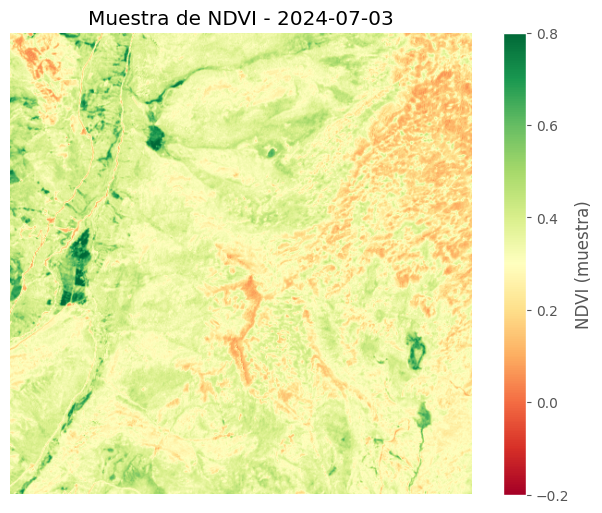


Estadísticas de NDVI (basadas en muestra):
- Valor mínimo: 0.0326
- Valor máximo: 0.8866
- Promedio: 0.3307


In [ ]:
# ============================================================================
# CÁLCULO DE NDVI
# ============================================================================
# Calculamos el Índice de Vegetación de Diferencia Normalizada (NDVI)

# Instalamos rasterio si es necesario
# !pip install rasterio matplotlib -q

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Verificar que tenemos las bandas necesarias
if 'image_paths' in locals() and 'red' in image_paths and 'nir' in image_paths:
    # Cargar las bandas roja y NIR
    print("Cargando bandas para calcular NDVI...")

    # Directorio para resultados
    result_dir = "data/examen/resultados"
    os.makedirs(result_dir, exist_ok=True)

    # Ruta para guardar el NDVI
    ndvi_path = os.path.join(result_dir, f"ndvi_{best_image['date']}.tif")

    # Procesamos por bloques para reducir el uso de memoria
    with rasterio.open(image_paths['red']) as red_src, \
         rasterio.open(image_paths['nir']) as nir_src:

        # Tomar el perfil de la banda roja
        profile = red_src.profile.copy()
        profile.update(
            dtype=rasterio.float32,
            count=1,
            compress='lzw'  # Compresión para reducir tamaño
        )

        # Calcular NDVI y guardar directamente
        with rasterio.open(ndvi_path, 'w', **profile) as dst:
            # Leer y procesar por bloques
            for ji, window in red_src.block_windows(1):
                red_data = red_src.read(1, window=window).astype(np.float32)
                nir_data = nir_src.read(1, window=window).astype(np.float32)

                # Calcular NDVI para este bloque
                ndvi_block = np.zeros_like(red_data, dtype=np.float32)

                # Evitar división por cero
                mask = (nir_data + red_data) > 0
                ndvi_block[mask] = (nir_data[mask] - red_data[mask]) / (nir_data[mask] + red_data[mask])

                # Escribir bloque
                dst.write(ndvi_block, 1, window=window)

    print(f"✅ NDVI guardado en: {ndvi_path}")

    # Leer una muestra pequeña para mostrar estadísticas
    with rasterio.open(ndvi_path) as src:
        # Leer solo una pequeña porción para estadísticas
        sample_size = min(500, src.width, src.height)
        sample_window = rasterio.windows.Window(0, 0, sample_size, sample_size)
        ndvi_sample = src.read(1, window=sample_window)

        # Visualizar muestra
        plt.figure(figsize=(8, 6))
        plt.imshow(ndvi_sample, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
        plt.colorbar(label='NDVI (muestra)')
        plt.title(f'Muestra de NDVI - {best_image["date"]}')
        plt.axis('off')
        plt.show()

        # Estadísticas básicas de la muestra
        ndvi_valid = ndvi_sample[ndvi_sample != 0]

        print("\nEstadísticas de NDVI (basadas en muestra):")
        print(f"- Valor mínimo: {np.min(ndvi_valid):.4f}")
        print(f"- Valor máximo: {np.max(ndvi_valid):.4f}")
        print(f"- Promedio: {np.mean(ndvi_valid):.4f}")
else:
    print("No se encontraron las bandas necesarias para calcular NDVI.")

Cargando bandas para calcular RVI...
✅ RVI guardado en: data/examen/resultados/rvi_2024-07-03.tif


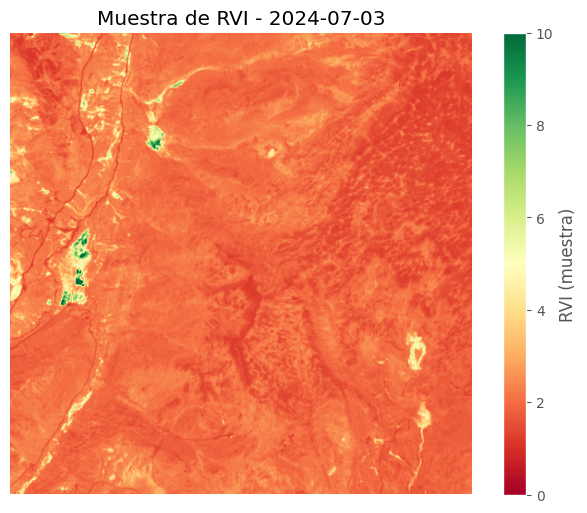


Estadísticas de RVI (basadas en muestra):
- Valor mínimo: 1.0673
- Valor máximo: 16.6332
- Promedio: 2.0581


In [ ]:
# ============================================================================
# CÁLCULO DE RVI (Ratio Vegetation Index)
# ============================================================================
# Calculamos el Ratio Vegetation Index (RVI) = NIR / RED

# Instalamos rasterio si es necesario
# !pip install rasterio matplotlib -q

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Verificar que tenemos las bandas necesarias
if 'image_paths' in locals() and 'red' in image_paths and 'nir' in image_paths:
    # Cargar las bandas roja y NIR
    print("Cargando bandas para calcular RVI...")

    # Directorio para resultados
    result_dir = "data/examen/resultados"
    os.makedirs(result_dir, exist_ok=True)

    # Ruta para guardar el RVI
    rvi_path = os.path.join(result_dir, f"rvi_{best_image['date']}.tif")

    # Procesamos por bloques para reducir el uso de memoria
    with rasterio.open(image_paths['red']) as red_src, \
         rasterio.open(image_paths['nir']) as nir_src:

        # Tomar el perfil de la banda roja
        profile = red_src.profile.copy()
        profile.update(
            dtype=rasterio.float32,
            count=1,
            compress='lzw'  # Compresión para reducir tamaño
        )

        # Calcular RVI y guardar directamente
        with rasterio.open(rvi_path, 'w', **profile) as dst:
            # Leer y procesar por bloques
            for ji, window in red_src.block_windows(1):
                red_data = red_src.read(1, window=window).astype(np.float32)
                nir_data = nir_src.read(1, window=window).astype(np.float32)

                # Calcular RVI para este bloque
                rvi_block = np.zeros_like(red_data, dtype=np.float32)

                # Evitar división por cero
                mask = red_data > 0  # Evitamos división por cero
                rvi_block[mask] = nir_data[mask] / red_data[mask]

                # Escribir bloque
                dst.write(rvi_block, 1, window=window)

    print(f"✅ RVI guardado en: {rvi_path}")

    # Leer una muestra pequeña para mostrar estadísticas
    with rasterio.open(rvi_path) as src:
        # Leer solo una pequeña porción para estadísticas
        sample_size = min(500, src.width, src.height)
        sample_window = rasterio.windows.Window(0, 0, sample_size, sample_size)
        rvi_sample = src.read(1, window=sample_window)

        # Visualizar muestra
        plt.figure(figsize=(8, 6))
        plt.imshow(rvi_sample, cmap='RdYlGn', vmin=0, vmax=10)
        plt.colorbar(label='RVI (muestra)')
        plt.title(f'Muestra de RVI - {best_image["date"]}')
        plt.axis('off')
        plt.show()

        # Estadísticas básicas de la muestra
        rvi_valid = rvi_sample[rvi_sample != 0]

        # Verificar si hay valores válidos
        if rvi_valid.size > 0:
            print("\nEstadísticas de RVI (basadas en muestra):")
            print(f"- Valor mínimo: {np.min(rvi_valid):.4f}")
            print(f"- Valor máximo: {np.max(rvi_valid):.4f}")
            print(f"- Promedio: {np.mean(rvi_valid):.4f}")
        else:
            print("No se encontraron valores válidos en la muestra de RVI.")
else:
    print("No se encontraron las bandas necesarias para calcular RVI.")


Recortando imagen por hexágono H3...
Usando NDVI...
CRS de la imagen: EPSG:32718
Límites de la imagen: BoundingBox(left=399960.0, bottom=8590240.0, right=509760.0, top=8700040.0)
CRS de los hexágonos: epsg:4326
Reproyectando hexágonos de epsg:4326 a EPSG:32718...
Hexágonos reproyectados.
De 18033 hexágonos, 13255 se superponen con la imagen.
Hexágono seleccionado: 898e6000dbbffff
Recorte guardado en: data/examen/resultados/ndvi_hex_recorte.tif


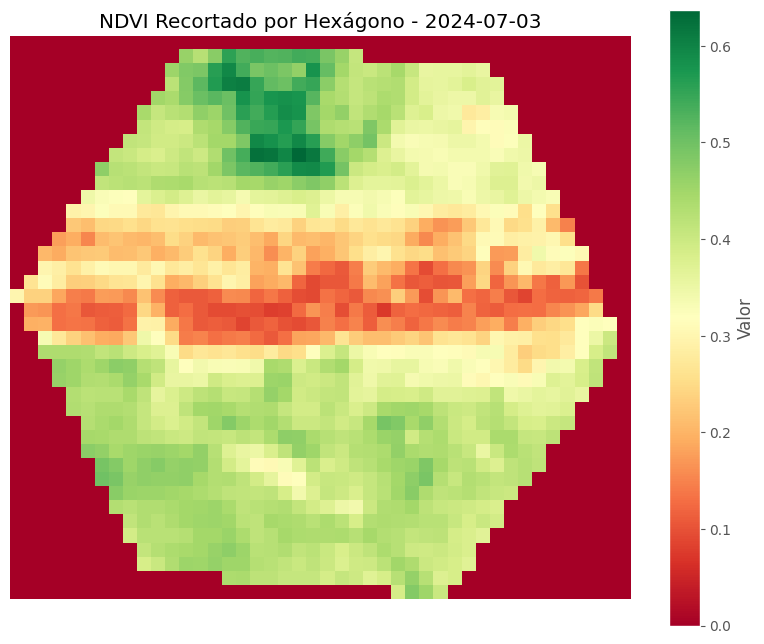

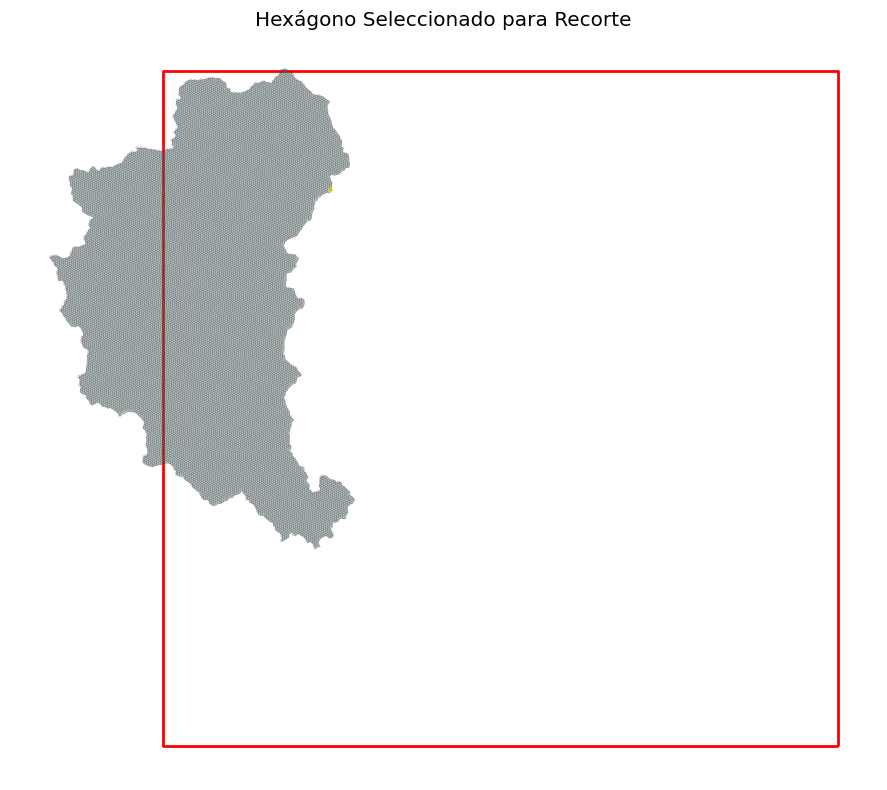


Análisis completado:
- Hexágono: 898e6000dbbffff
- Resolución H3: 9
- Imagen recortada: data/examen/resultados/ndvi_hex_recorte.tif


In [ ]:
# ============================================================================
# RECORTE DE IMAGEN POR HEXÁGONO H3
# ============================================================================
# Seleccionamos un hexágono y recortamos la imagen por ese hexágono
# Asegurándonos de que ambos estén en el mismo sistema de coordenadas

import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, box

# Verificar que tenemos los datos necesarios
if 'h3_gdf' in locals() and ('ndvi_path' in locals() or 'image_paths' in locals()):
    print("Recortando imagen por hexágono H3...")

    # Decidir qué imagen recortar (NDVI o una banda satelital)
    if 'ndvi_path' in locals():
        print("Usando NDVI...")
        input_path = ndvi_path
        output_path = "data/examen/resultados/ndvi_hex_recorte.tif"
        title = f"NDVI Recortado por Hexágono - {best_image['date']}"
        cmap = 'RdYlGn'
    elif 'image_paths' in locals() and 'nir' in image_paths:
        print("Usando banda NIR...")
        input_path = image_paths['nir']
        output_path = "data/examen/resultados/nir_hex_recorte.tif"
        title = f"Banda NIR Recortada por Hexágono - {best_image['date']}"
        cmap = 'viridis'
    else:
        print("Usando banda Roja...")
        input_path = image_paths['red']
        output_path = "data/examen/resultados/red_hex_recorte.tif"
        title = f"Banda Roja Recortada por Hexágono - {best_image['date']}"
        cmap = 'Reds'

    # Obtener información del sistema de coordenadas de la imagen
    with rasterio.open(input_path) as src:
        img_crs = src.crs
        print(f"CRS de la imagen: {img_crs}")

        # Obtener los límites de la imagen
        img_bounds = src.bounds
        print(f"Límites de la imagen: {img_bounds}")

    # Verificar el CRS de los hexágonos
    print(f"CRS de los hexágonos: {h3_gdf.crs}")

    # Reproyectar los hexágonos al CRS de la imagen si es necesario
    if h3_gdf.crs != img_crs:
        print(f"Reproyectando hexágonos de {h3_gdf.crs} a {img_crs}...")
        h3_gdf_projected = h3_gdf.to_crs(img_crs)
        print("Hexágonos reproyectados.")
    else:
        h3_gdf_projected = h3_gdf

    # Comprobar qué hexágonos se superponen con la imagen
    # Convertimos los límites de la imagen a un polígono de shapely
    img_poly = box(img_bounds.left, img_bounds.bottom, img_bounds.right, img_bounds.top)

    # Verificar qué hexágonos intersectan con la imagen
    intersections = h3_gdf_projected.intersects(img_poly)
    overlapping_hexes = h3_gdf_projected[intersections]

    print(f"De {len(h3_gdf_projected)} hexágonos, {len(overlapping_hexes)} se superponen con la imagen.")

    if len(overlapping_hexes) > 0:
        # Seleccionar el primer hexágono que se superpone
        selected_hex = overlapping_hexes.iloc[0]
        print(f"Hexágono seleccionado: {selected_hex['h3_index']}")

        # Convertir geometría a formato GeoJSON
        hex_geom = [mapping(selected_hex.geometry)]

        # Realizar el recorte
        with rasterio.open(input_path) as src:
            try:
                # Recortar la imagen al hexágono
                out_image, out_transform = mask(src, hex_geom, crop=True)

                # Copiar el perfil y actualizarlo
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Guardar el recorte
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

                print(f"Recorte guardado en: {output_path}")

                # Visualizar el recorte
                plt.figure(figsize=(10, 8))
                plt.imshow(out_image[0], cmap=cmap)
                plt.title(title)
                plt.colorbar(label='Valor')
                plt.axis('off')
                plt.show()

                # Visualizar el hexágono en un mapa
                fig, ax = plt.subplots(figsize=(10, 8))

                # Crear un GeoDataFrame con el polígono de la imagen
                img_gdf = gpd.GeoDataFrame(geometry=[img_poly], crs=img_crs)

                # Dibujar los límites de la imagen
                img_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2, label='Límites de la imagen')

                # Dibujar el área protegida
                if gdf_area.crs != img_crs:
                    gdf_area_projected = gdf_area.to_crs(img_crs)
                else:
                    gdf_area_projected = gdf_area
                gdf_area_projected.plot(ax=ax, color='green', alpha=0.3, edgecolor='black')

                # Dibujar todos los hexágonos
                h3_gdf_projected.plot(ax=ax, color='orange', alpha=0.2, edgecolor='blue')

                # Destacar el hexágono seleccionado
                gpd.GeoDataFrame(geometry=[selected_hex.geometry], crs=h3_gdf_projected.crs).plot(
                    ax=ax, color='red', alpha=0.5, edgecolor='yellow', linewidth=2
                )

                plt.title('Hexágono Seleccionado para Recorte')
                plt.axis('off')
                plt.tight_layout()
                plt.show()

                print("\nAnálisis completado:")
                print(f"- Hexágono: {selected_hex['h3_index']}")
                print(f"- Resolución H3: {resolution}")
                print(f"- Imagen recortada: {output_path}")
            except Exception as e:
                print(f"Error al recortar: {e}")
                print("Detalles adicionales:")
                print(f"- Límites hexágono: {selected_hex.geometry.bounds}")
                print(f"- Límites imagen: {img_bounds}")
    else:
        print("No hay hexágonos que se superpongan con la imagen.")
        print("Esto puede ocurrir por:")
        print("1. Los sistemas de coordenadas son muy diferentes")
        print("2. El área protegida está fuera del área de la imagen")
        print("3. Hay un error en las coordenadas")

        # Mostrar los límites para diagnóstico
        print("\nLímites del área protegida:")
        print(gdf_area.total_bounds)

        print("\nLímites de la imagen:")
        print(img_bounds)
else:
    print("No se encontraron los datos de hexágonos H3 o imágenes satelitales.")

In [ ]:
# ============================================================================
# CONCLUSIONES SIMPLES
# ============================================================================
# Resumen del análisis

print("===== RESUMEN DEL ANÁLISIS =====")
print(f"\nÁrea protegida: {area_nombre}")
print(f"Fecha de la imagen: {best_image['date']}")
print(f"Cobertura de nubes: {best_image['cloud_cover']:.2f}%")

print("\nEn este trabajo hemos:")
print("1. Obtenido los límites de un área protegida desde OpenStreetMap")
print("2. Creado una grilla de hexágonos H3 sobre el área")
print(f"3. Descargado imágenes satelitales Sentinel-2 ({best_image['date']})")
print("4. Calculado el índice RVI para evaluar la vegetación")
print("5. Visualizado el área usando diferentes herramientas")

print("\nPosibles aplicaciones:")
print("- Monitoreo de la salud de la vegetación en áreas protegidas")
print("- Planificación de recorridos para guardaparques")
print("- Identificación de zonas prioritarias para conservación")
print("- Detección de cambios a lo largo del tiempo (usando imágenes de diferentes fechas)")

print("\nPróximos pasos:")
print("- Comparar con imágenes de diferentes estaciones")
print("- Incorporar otros índices como NDWI (agua) o NDBI (urbano)")
print("- Realizar clasificación supervisada del área")

===== RESUMEN DEL ANÁLISIS =====

Área protegida: Reserva Paisajística Nor Yauyos-Cochas
Fecha de la imagen: 2024-07-03
Cobertura de nubes: 0.00%

En este trabajo hemos:
1. Obtenido los límites de un área protegida desde OpenStreetMap
2. Creado una grilla de hexágonos H3 sobre el área
3. Descargado imágenes satelitales Sentinel-2 (2024-07-03)
4. Calculado el índice NDVI para evaluar la vegetación
5. Visualizado el área usando diferentes herramientas

Posibles aplicaciones:
- Monitoreo de la salud de la vegetación en áreas protegidas
- Planificación de recorridos para guardaparques
- Identificación de zonas prioritarias para conservación
- Detección de cambios a lo largo del tiempo (usando imágenes de diferentes fechas)

Próximos pasos:
- Comparar con imágenes de diferentes estaciones
- Incorporar otros índices como NDWI (agua) o NDBI (urbano)
- Realizar clasificación supervisada del área
